# The grass.jupyter Package

This notebook introduces the [_grass.jupyter_](https://grass.osgeo.org/grass-stable/manuals/libpython/grass.jupyter.html) package which simplifies the usage of *GRASS GIS* in *Jupyter Notebook*.

The _grass.jupyter_ package was initially written as part of [Google Summer of Code in 2021](https://trac.osgeo.org/grass/wiki/GSoC/2021/JupyterAndGRASS) by Caitlin Haedrich and was experimentally included in version 8.0.0. Caitlin further improved it thanks to the [GRASS Mini Grant 2022](https://trac.osgeo.org/grass/wiki/GSoC/2021/JupyterAndGRASS/MiniGrant2022). The package was officially released for the first time as part of version 8.2.0. Credits for mentoring and additional development go to Vaclav Petras, Helena Mitasova, Stefan Blumentrath, and Anna Petrasova as well as to many members of the GRASS community who provided important feedback.

In addition to simplifying the launch of *GRASS GIS* with a dedicated _init_ function, _grass.jupyter_ has two main display classes, _Map_ and _InteractiveMap_. Using the GRASS rendering engine in the background, _Map_ creates maps as PNG images. _InteractiveMap_ displays GRASS rasters and vectors either with [*folium*](http://python-visualization.github.io/folium/), or [*ipyleaflet*](https://ipyleaflet.readthedocs.io/en/latest/), both are [*leaflet*](https://leafletjs.com/)-based libraries for Python. The package includes also _Map3D_ and [_TimeSeriesMap_](temporal.ipynb).

This interactive notebook is available online thanks to the [Binder](https://mybinder.org) service. To run the select part (called a *cell*), hit `Shift + Enter`.

## Start GRASS GIS

In [1]:
# Import Python standard library and IPython packages we need.
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init("../../../../grassdata", "nc_basic_spm_grass7", "user1")

# Set computational region to the elevation raster.
gs.run_command("g.region", raster="elevation")

## GRASS Renderer

The `Map` class creates and displays GRASS maps as PNG images. There are two ways to add elements to the display. First, the name of the *GRASS* display module can be called as an attribute by replacing the "." with "\_" in the module name. For example:
````
m = Map()
m.d_rast(map="elevation")
````

Alternatively, *GRASS* display modules can be called with the `run()` method:
````
m = Map()
m.run("d.rast", map="elevation")
````

To display the image, call `show()`.

In [2]:
# Create Map instance
example_map = gj.Map()

In [3]:
# Add a raster, vector and legend to the map
example_map.d_rast(map="elevation")
example_map.d_vect(map="streams")
example_map.d_legend(raster="elevation", at=(55, 95, 80, 84), flags="b")

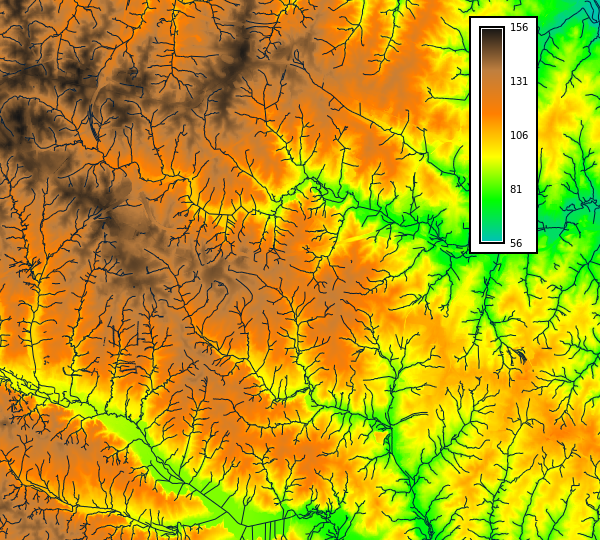

In [4]:
# Display map
example_map.show()

We can also have multiple instances of `Map`. Here, we create another map then go back and modify the first map.

In [5]:
# Make a second instance.
# Just for variety, we'll make this one a different size
small_map = gj.Map(height=200, width=220)

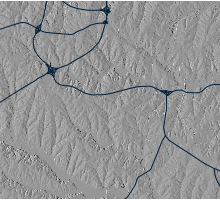

In [6]:
# Add a some layers
# We can also add layers with the run() methods
small_map.run("d.rast", map="elevation_shade")
small_map.run("d.vect", map="roadsmajor")

# Display second map
small_map.show()

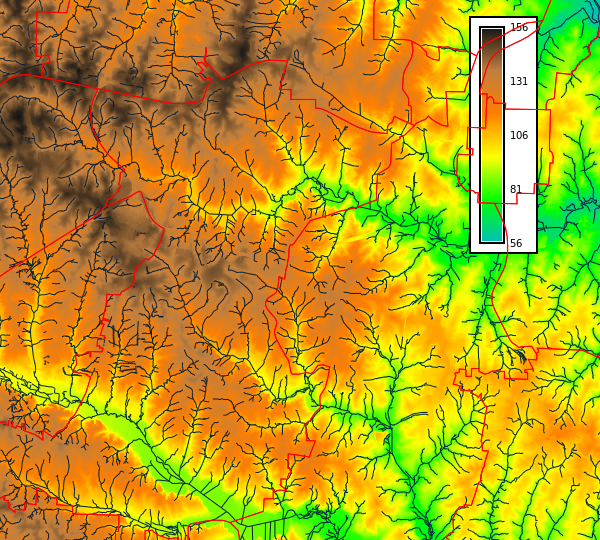

In [7]:
# Then, we return to the first instance and continue to modify and display it
# Notice that layers a drawn in the order they are added
example_map.run("d.vect", map="zipcodes", color="red", fill_color="none")
example_map.show()

By default the display extent (and resolution if applicable) is derived from the first raster or vector layer:

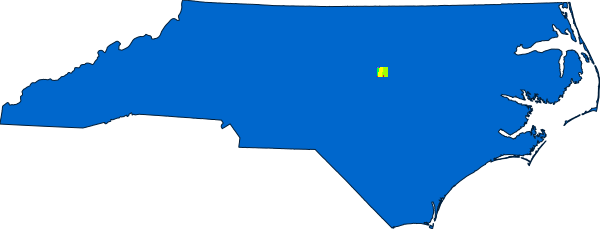

In [8]:
nc_map = gj.Map()
nc_map.d_vect(map="boundary_state")
nc_map.d_rast(map="geology")
nc_map.show()

To respect computational region, set `use_region=True`:

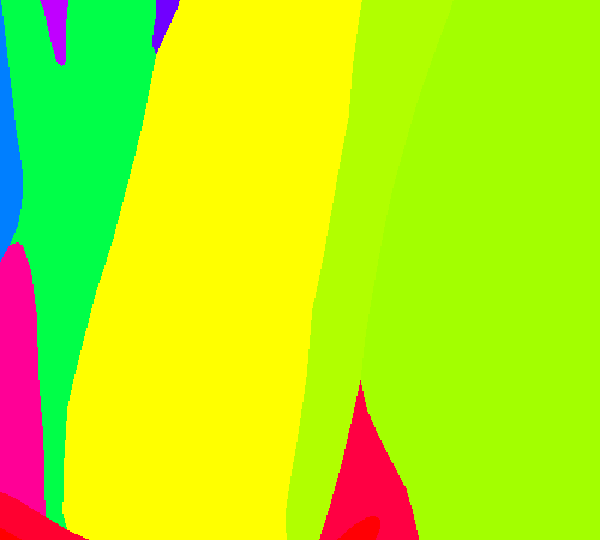

In [9]:
geol_map = gj.Map(use_region=True)
geol_map.d_vect(map="boundary_state")
geol_map.d_rast(map="geology")
geol_map.show()

You can also use a saved region:

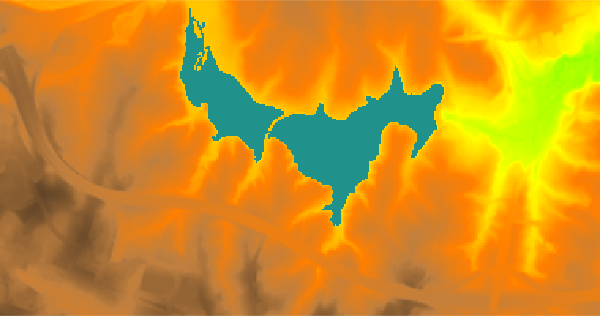

In [10]:
gs.run_command("g.region", save="myregion", n=224000, s=222000, w=633500, e=637300)
myregion_map = gj.Map(saved_region="myregion")
myregion_map.d_rast(map="elevation")
myregion_map.d_rast(map="lakes")
myregion_map.show()

## Interactive Map Display

The `InteractiveMap` class displays *GRASS GIS* rasters and vectors with [*folium*](http://python-visualization.github.io/folium/) or [*ipyleaflet*](https://ipyleaflet.readthedocs.io/en/latest/).
Backend is detected automatically; when both libraries are available, ipyleaflet is used. The backend can be also selected with the `map_backend` parameter.

**Only when using ipyleaflet**, the map display includes a button for querying data ( &#8505; ), a button for displaying and editing computational region (&#9633;), and a button for drawing simple vector geometries (&#128394;) that can be saved as a GRASS native vector map.

1. Query raster/vector layers: Click the **info** button ( &#8505; ) to enable query mode, then select a point on the map to retrieve information. Toggle the button off when finished.
2. View and edit the computational region: Click the **computational region** button (&#9633;) to display and optionally adjust the region. Update it by clicking **Update region**, then toggle the button off when done.
3. Draw and save geometries: Click the **pencil** button (&#128394;) to draw shapes on the map, name the vector map, and save it. The geometry will be added as a new layer and the drawing tool will close automatically.


In [11]:
# Create Interactive Map
raleigh_map = gj.InteractiveMap(width=600)

In [12]:
# Add raster, vector and layer control to map
raleigh_map.add_raster("elevation")
raleigh_map.add_vector("roadsmajor")

In [13]:
# Display Interactive Map
raleigh_map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Save InteractiveMap as HTML

To share or embed the map in a website, we can export it has an HTML file.

In [14]:
raleigh_map.save(filename="raleigh_map.html")

## GRASS-folium Integration

We can also pass GRASS rasters and vectors directly to folium with the Raster and Vector classes. This provides much more flexibility when creating maps since we can access all of folium's capabilities.


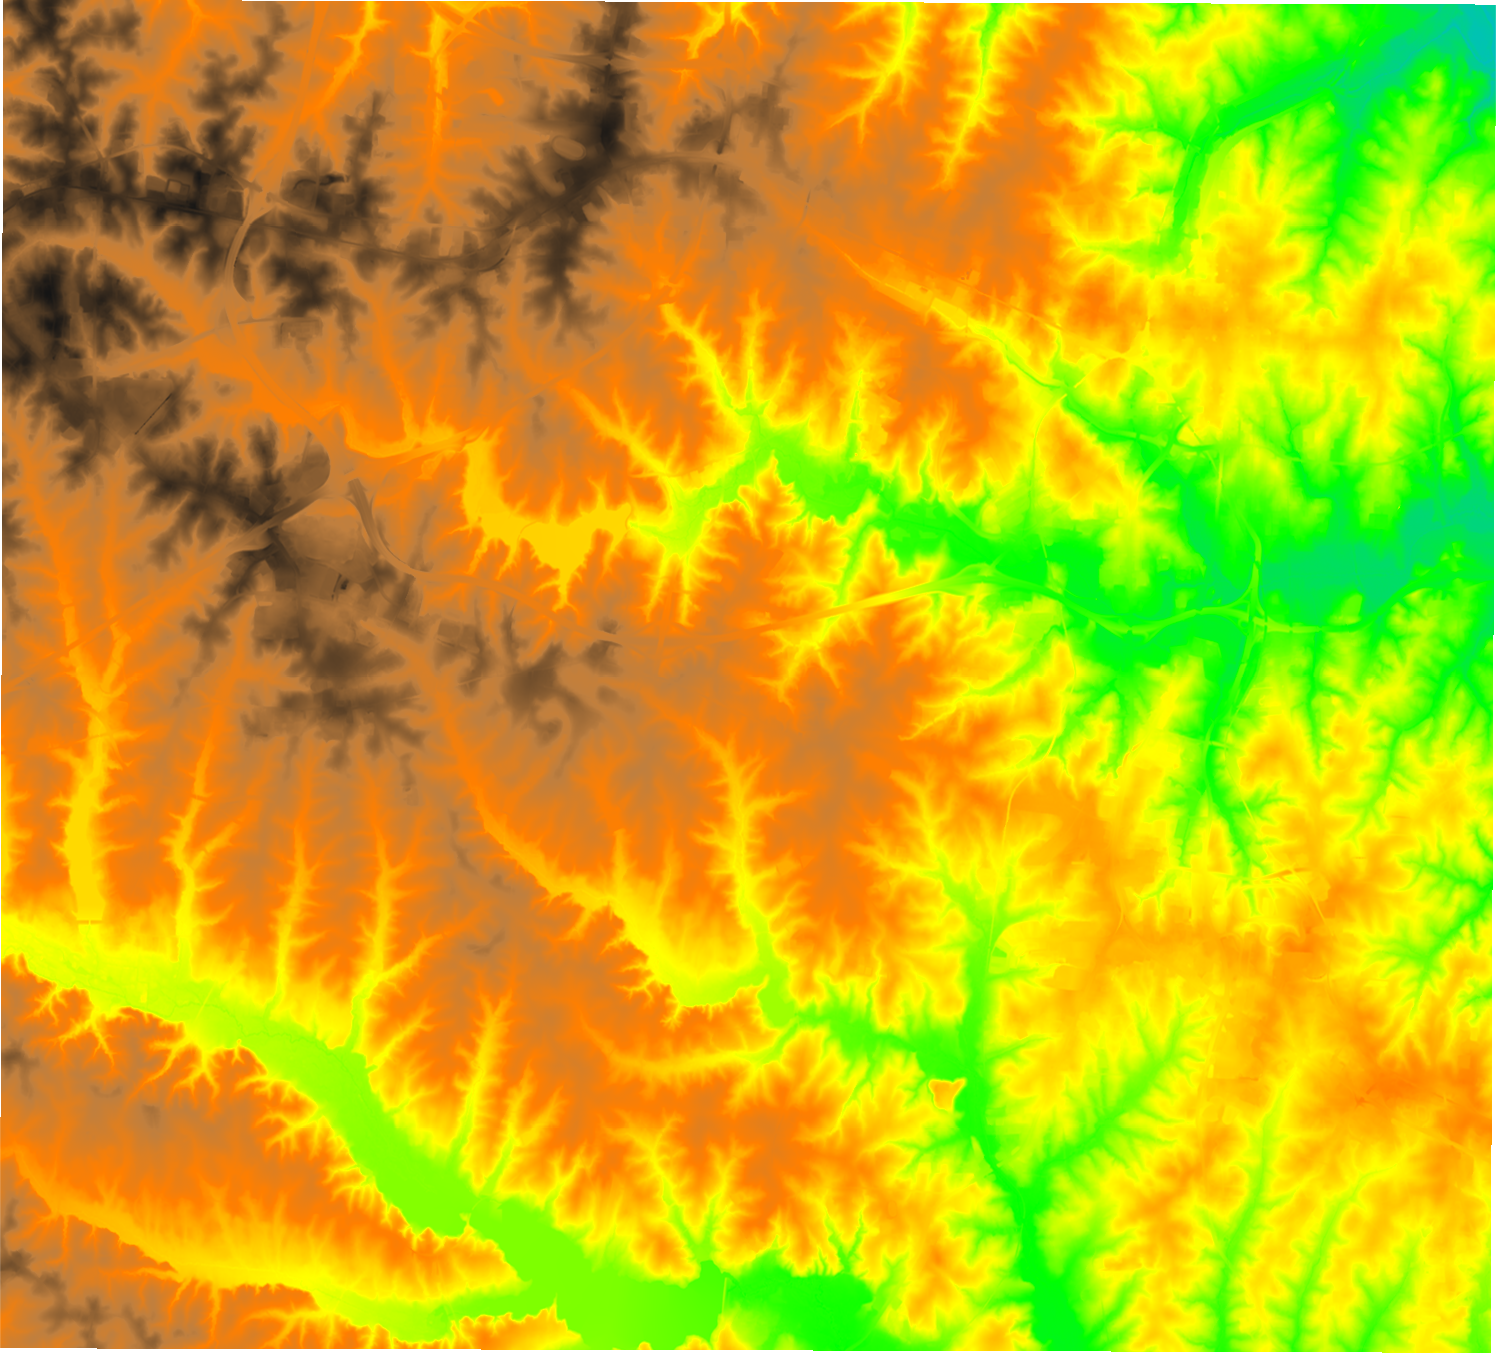

In [15]:
import folium


# Create a map
m = folium.Map(location=[35.761168, -78.668271], zoom_start=13)

# Create and add elevation layer to map
gj.Raster("elevation", opacity=0.5).add_to(m)

# Do some cool folium stuff!
# Like make a tooltip
tooltip = "Click me!"
# and add a marker
folium.Marker(
    [35.781608, -78.675800], popup="<i>Point of Interest</i>", tooltip=tooltip
).add_to(m)

# Display map
m

## GRASS-ipyleaflet Integration

We can also pass GRASS rasters and vectors directly to ipyleaflet with the Raster and Vector classes. This provides much more flexibility when creating maps since we can access all of ipyleaflet's capabilities.

In [16]:
import ipyleaflet

# Create map
m = ipyleaflet.Map(center=[35.761168, -78.668271], zoom=13)

# Create and add elevation layer to map
gj.Raster("elevation", opacity=0.5).add_to(m)

# Do some cool ipyleaflet stuff!
# Like make a tooltip
title = "Click me!"
# and add a marker
marker = ipyleaflet.Marker(name="marker", location=(35.781608, -78.675800), title=title)

# Add the marker to the map
m.add(marker)

control = ipyleaflet.LayersControl(position="topright")
m.add(control)
m

Map(center=[35.761168, -78.668271], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

## GRASS 3D Renderer

The `Map3D` class creates 3D visualizations as PNG images. The *m.nviz.image* module is used in the background and the function `render()` accepts parameters of this module.
The `Map3D` objects have `overlay` attribute which can be used in the same way as `Map` and 2D images on top of the 3D visualization.
To display the image, call `show()`.

First, let's create the object:

In [17]:
elev_map = gj.Map3D()

Now, render a 3D visualization of an elevation raster as a surface colored using, again, the elevation raster:

In [18]:
elev_map.render(elevation_map="elevation", color_map="elevation", perspective=20)

To add a raster legend on the image as an overlay using the 2D rendering capabilities accessible with `overlay.d_legend`:

In [19]:
elev_map.overlay.d_legend(raster="elevation", at=(60, 97, 87, 92))

Finally, we show 

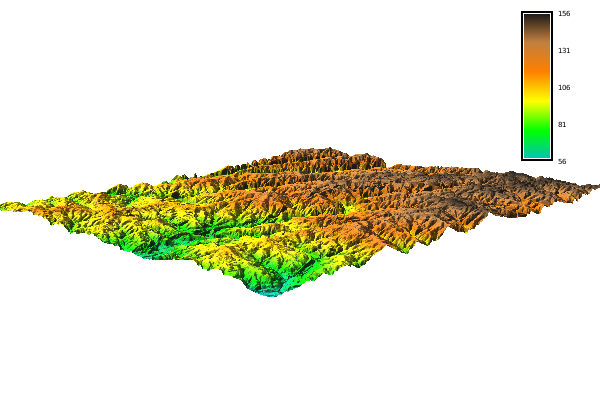

In [20]:
elev_map.show()

Now, let's color the elevation surface using a landuse raster (note that the call to `render` removes the result of the previous `render` as well as the current overlays):

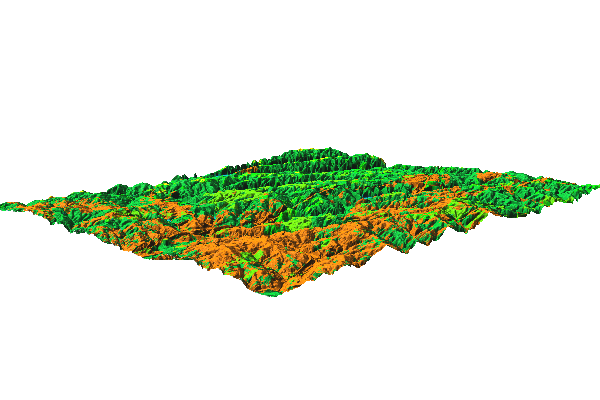

In [21]:
elev_map.render(elevation_map="elevation", color_map="landuse", perspective=20)
elev_map.show()

## Animating Series of Maps

The `SeriesMap` class animates a series of maps. The `ipywidgets` slider allows users to slide between maps and play a continuous loop. This class is similar to the `TimeSeriesMap` class for space-time datasets and shown in the [temporal notebook](./temporal.ipynb).

In [22]:
!r.slope.aspect elevation=elevation slope=slope

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Slope raster map <slope> complete


#### Managing Core Usage with SeriesMap

The `SeriesMap` module automatically uses multiple CPU cores to improve rendering performance. If you want to control the number of cores used, you can set the `NPROCS` [variable](https://grass.osgeo.org/grass83/manuals/variables.html#list-of-selected-grass-gisenv-variables).
To specify the number of cores for rendering, set the `NPROCS` variable to the desired number of cores before running `gj.SeriesMap`. For example, to use 4 cores, execute:

   ```
   gs.run_command("g.gisenv", set="NPROCS=4")
   ```

In [ ]:
series = gj.SeriesMap(height=500)
series.add_rasters(["elevation", "elevation_shade", "slope"])
series.add_vectors(["streams", "streets", "points_of_interest"])
series.d_vect(map="streets")
series.d_barscale()
series.show()  # Create Slider

The series can also be saved as a GIF.

In [ ]:
series.save("image.gif")

## Switching Mapsets and Session Management

The `init` function returns a reference to a session object which can be used to manipulate the current session. The session is global, i.e., the global state of the environment is changed. The session object is a handle for accessing this global session. When the kernel for the notebooks shuts down or is restarted, the session ends automatically. The session can be explicitly ended using `session.finish()`, but that's usually not needed in notebooks.

Additionally, the session object can be used to change the current mapset. Here, we will switch to mapset called *PERMANENT*:

In [ ]:
session.switch_mapset("PERMANENT")

Now we could add more data to the PERMANENT mapset or modify the existing data there. We don't need to do anything there, so we switch back to the mapset we were in before:

In [ ]:
session.switch_mapset("user1")